In [2]:
import torch
import torch.nn as nn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

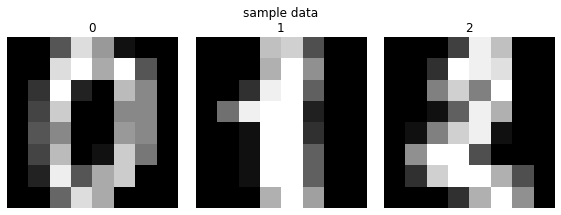

In [3]:
data_digits = load_digits()
fig,ax = plt.subplots(1,3)
fig.set_size_inches(8,3)
for i in range(3):  
    ax[i].imshow(data_digits.images[i], cmap='gray')
    ax[i].set_title(data_digits.target[i])
    ax[i].set_axis_off()
fig.suptitle("sample data")
plt.tight_layout()
plt.show()

##### Number distribution in dataset

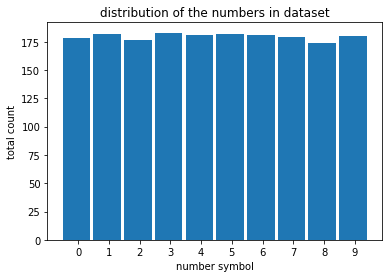

In [4]:
plt.hist(data_digits.target, bins=10, rwidth=0.9)#
plt.xticks([0.5 + (i)*9/10 for i in range(len(data_digits.target_names))],data_digits.target_names)
plt.xlabel("number symbol")
plt.ylabel("total count")
plt.title("distribution of the numbers in dataset")
plt.show()

## Model

In [27]:
from typing import Tuple
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3)
        self.conv2 = nn.Conv2d(6,24,3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.flatten1 = nn.Flatten()
        self.flatten2 = nn.Flatten(-2, 1)
        self.FC1 = nn.Linear(96, 20)
        self.FC2 = nn.Linear(20,12)
        self.FC3 = nn.Linear(12,12)
        self.out = nn.Linear(12,10)
        self.model = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.conv2,
            nn.ReLU(),
            self.pool1,
            self.flatten1,
            self.flatten2,
            self.FC1,
            nn.ReLU(),
            self.FC2,
            nn.ReLU(),
            self.FC3,
            nn.ReLU(),
            self.out,
            nn.Softmax(dim = -1)
        )

    def forward(self,input):
        return self.model(input)


In [28]:
x = torch.from_numpy(data_digits.images).type(torch.float)
y = torch.from_numpy(data_digits.target).type(torch.float)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=12)

In [36]:
model_0 = CNN()
with torch.inference_mode():
    pred = model_0(torch.reshape(xtrain[0], (1, 8, 8)))
    print(pred)

tensor([0.0875, 0.0853, 0.0729, 0.0896, 0.1195, 0.0785, 0.1278, 0.1414, 0.1080,
        0.0895])


In [35]:
from torch.optim import SGD
def train(model : CNN, nr_epoch, train_data, train_target, test_data, test_target, learning_rate = 1e-4):
    optimizer = SGD(model.parameters(), momentum=0.3, lr = learning_rate)
    loss_func = nn.CrossEntropyLoss()
    test_acc_hist = []
    train_acc_hist = []
    test_loss_hist = []
    train_loss_hist = []
    for epoch in range(nr_epoch):
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        for t in range(len(train_data)):
            prediction = model(torch.reshape(train_data[t], (1, 8, 8)))
            target_value = torch.tensor([(0 if i != train_target[t] else 1) for i in range(10)],dtype=torch.float)
            loss_value = loss_func(prediction,target_value)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            epoch_loss += loss_value.item()
            if torch.argmax(prediction) == train_target[t]:
                epoch_accuracy += 1
        epoch_test_loss = 0.0
        epoch_test_accuracy = 0.0
        with torch.inference_mode():
            for i in range(len(test_data)):
                prediction = model(torch.reshape(test_data[i], (1, 8, 8)))
                target_value = torch.tensor([(0 if j != test_target[i] else 1) for j in range(10)],dtype=torch.float)
                loss_value = loss_func(prediction,target_value)
                epoch_test_loss+=loss_value.item()
                if torch.argmax(prediction) == test_target[i]:
                    epoch_test_accuracy += 1
            
        
        print(f"""[{epoch}] avg loss: {epoch_loss/len(train_data)}, avg test loss: {epoch_test_loss/len(test_data)},
              train accuracy: {epoch_accuracy/len(train_data)}, test accuracy: {epoch_test_accuracy/len(test_data)}
              """)
        test_acc_hist.append(epoch_test_accuracy/len(test_data))
        train_acc_hist.append(epoch_accuracy/len(train_data))
        test_loss_hist.append(epoch_test_loss/len(test_data))
        train_loss_hist.append(epoch_loss/len(train_data))
    return test_acc_hist,train_acc_hist,test_loss_hist,train_loss_hist



In [37]:
test_acc_hist,train_acc_hist,test_loss_hist,train_loss_hist = train(model_0,70,xtrain,ytrain,xtest,ytest,learning_rate=0.006)


[0] avg loss: 2.302210306241932, avg test loss: 2.3005460176202988,
              train accuracy: 0.0953375086986778, test accuracy: 0.1388888888888889
              
[1] avg loss: 2.2921977504393087, avg test loss: 2.26928427848551,
              train accuracy: 0.20041753653444677, test accuracy: 0.14166666666666666
              
[2] avg loss: 2.1087102501775625, avg test loss: 2.0104488829771676,
              train accuracy: 0.35977731384829503, test accuracy: 0.4444444444444444
              
[3] avg loss: 1.9804704752578948, avg test loss: 1.9486603349447251,
              train accuracy: 0.48086290883785665, test accuracy: 0.5333333333333333
              
[4] avg loss: 1.8951921968221166, avg test loss: 1.8811659872531892,
              train accuracy: 0.5741127348643006, test accuracy: 0.5833333333333334
              
[5] avg loss: 1.8586798048550335, avg test loss: 1.9166973802778455,
              train accuracy: 0.6019485038274183, test accuracy: 0.5472222222222223
      

KeyboardInterrupt: ignored

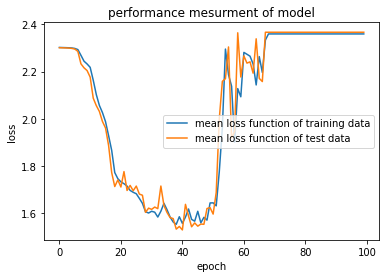

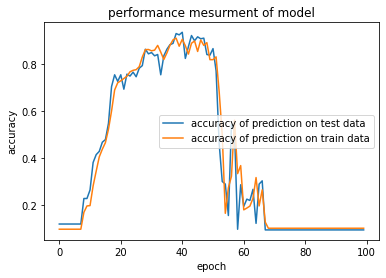

In [32]:
plt.plot(train_loss_hist,label="mean loss function of training data")
plt.plot(test_loss_hist, label="mean loss function of test data")
plt.legend()
plt.title("performance mesurment of model")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.plot(test_acc_hist, label="accuracy of prediction on test data")
plt.plot(train_acc_hist, label="accuracy of prediction on train data")
plt.legend()
plt.title("performance mesurment of model")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [11]:
path = "./numbers_model.pth"
torch.save(model_0.state_dict(), path) 